<a href="https://colab.research.google.com/github/Leo166/gbio_project/blob/main/Projet_gbio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import truncnorm
import random
import math
from scipy.optimize import leastsq

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D 

------------------
## **Characterisation of the sensor inputs**
-----------------

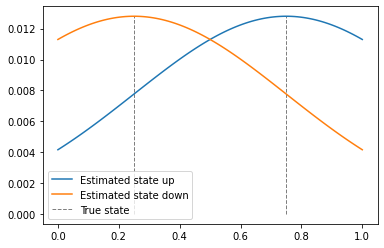

In [ ]:
# Function to generate the gaussian probabilities of a vector x
# Parameter: x - numpy array - numbers where to evaluate the distribution
#            mean - float - mean of of the normal distribution
#            strd - float - standard deviation of the normal distribution
# Return: the probabilities at x
def gaussian_distribution(x, mean, strd):
  prob = (1/np.sqrt(2*np.pi*strd**2)) * np.exp(- 0.5/strd**2 * (mean - x) ** 2)
  prob = prob / prob.sum()
  return prob

mean_up = 0.75
strd_up = 0.5
mean_down = 0.25
strd_down = 0.5
x = np.linspace(-0,1,100)

# True and estimated state of the arrow up
p_up = gaussian_distribution(x, mean_up, strd_up)
# True and estimated state of the arrow down
p_down = gaussian_distribution(x, mean_down, strd_down)

plt.plot(x, p_up, color="C0", label='Estimated state up')
plt.vlines(mean_up, 0, np.max(p_up), colors='C7', linestyles='dashed', label='True state', linewidth=1)
plt.plot(x, p_down, color="C1", label='Estimated state down')
plt.vlines(mean_down, 0, np.max(p_down), colors='C7', linestyles='dashed', linewidth=1)
plt.legend()
plt.show()

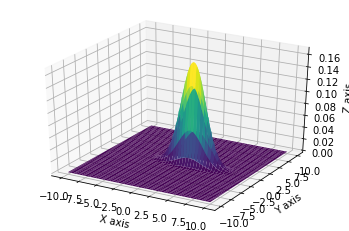

In [ ]:
#EXAMPLE INTERNET

#Parameters to set
mu_x = 2
variance_x = 3

mu_y = 0
variance_y = 0.3

#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

--------------
## **Sequential probability ratio test (SPRT) - Decision making**
---------------

Likelihood = probabilité que l'estimation provienne de la vraie distribution

**Distribution of the likelihood and log-likelihood ratio**

1.0


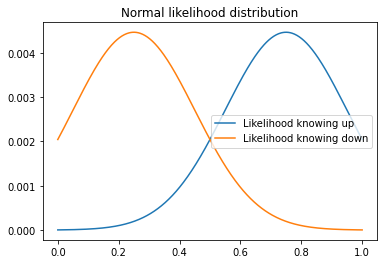

In [ ]:
# Function to calculate the log-likelihood ratio of normal distribution
def normal_ll_ratio(sensor_inputs, mean_down, mean_up, strd_down, strd_up):
  ll_ratio = np.log(strd_down/strd_up) + 0.5 * (sensor_inputs-mean_down)**2/(strd_down)**2 - 0.5 * (sensor_inputs-mean_up)**2/(strd_up)**2
  return ll_ratio

def normal_distribution(x, mean, strd):
  prob = (1/np.sqrt(2*np.pi*strd**2)) * np.exp(- 0.5/strd**2 * (mean - x) ** 2)
  prob = prob / prob.sum()
  return prob
 
x = np.linspace(0, 1, 500)
p_up = normal_distribution(x, 0.75, 0.2)
p_down = normal_distribution(x, 0.25, 0.2)
print(np.sum(p_up))
plt.plot(x, p_up, label="Likelihood knowing up")
plt.plot(x, p_down, label="Likelihood knowing down")
plt.title("Normal likelihood distribution")
plt.legend()
plt.show()

1.0


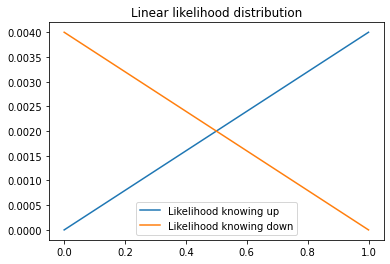

In [ ]:
# Function to generate the probabilities at x according to a linear distribution
def linear_distribution(x, m, p):
  prob = m*x + p
  prob /= prob.sum()
  return prob

# Function to calculate the log-likelihood ratio of linear distribution
def linear_ll_ratio(sensor_inputs, m, p):
  p_up = linear_distribution(sensor_inputs, m, p)
  p_down = linear_distribution(1-sensor_inputs, -m, p)
  ll_ratio = np.log(linear_distribution(sensor_inputs, m, p)/linear_distribution(sensor_inputs, m, p))
  x = np.linspace(0, 1, 500)
  p = linear_distribution(x, 1, 0)
  p1 = linear_distribution(1-x, -1, 0)
  p_down /= np.sum(p1)
  p_up /= np.sum(p)
  return ll_ratio

x = np.linspace(0, 1, 500) 
p_up = linear_distribution(x, 1, 0)
# p_down = np.flip(linear_distribution(x, 1, 0.5))
p_down = linear_distribution(1-x, -1, 0)
print(np.sum(p_up))
plt.plot(x, p_up, label="Likelihood knowing up")
plt.plot(x, p_down, label="Likelihood knowing down")
plt.title("Linear likelihood distribution")
plt.legend()
plt.show()

1.0


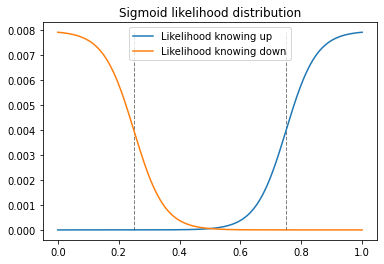

In [ ]:
# Function to generate the probabilities at x according to a sigmoid distribution
def sigmoid_distribution(x, mu, s):
  prob = 1/(1 + np.exp(-(x-mu)/s)) #probabilité
  # prob = prob / prob.sum()
  return prob

# Function to calculate the log-likelihood ratio of sigmoid distribution
def sigmoid_ll_ratio(sensor_inputs, mu_down, mu_up, s):
  p_down = sigmoid_distribution(1-sensor_inputs, 1-mu_down, s)
  p_up = sigmoid_distribution(sensor_inputs, mu_up, s)
  x = np.linspace(0, 1, 500) 
  p = sigmoid_distribution(1-x, 1-mu_down, s)
  p1 = sigmoid_distribution(x, mu_up, s)
  p_down /= np.sum(p)
  p_up /= np.sum(p1)
  ll_ratio = np.log(p_up/p_down)
  # plt.plot(sensor_inputs, p_up,'o', markersize=5)
  # plt.plot(sensor_inputs, p_down, 'o', markersize=5)
  # plt.show()
  return ll_ratio

mu_up = 0.75
s = 0.05
mu_down = 0.25
x = np.linspace(0, 1, 500) 
p_up = sigmoid_distribution(x, mu_up, s)
p_up /= np.sum(p_up)
p_down = sigmoid_distribution(1-x, 1-mu_down, s)
p_down /= np.sum(p_down)

print(np.sum(p_up))
plt.plot(x, p_up, label="Likelihood knowing up")
plt.vlines(mu_up, 0, np.max(p_down), colors='C7', linestyles='dashed', linewidth=1)
plt.plot(x, p_down, label="Likelihood knowing down")
plt.vlines(mu_down, 0, np.max(p_down), colors='C7', linestyles='dashed', linewidth=1)
plt.title("Sigmoid likelihood distribution")
plt.legend()
plt.show()


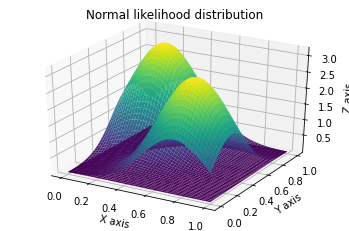

In [ ]:
def multivariate_gaussian(meanx, meany, strdx, strdy):
  prob = multivariate_normal([meanx, meany], [[strdx, 0], [0, strdy]])
  return prob

def multivariate_ll_ratio(sensor_inputs, mean_down, mean_up, strd_down, strd_up):
  ll_ratio = np.log(strd_down/strd_up) + 0.5 * (sensor_inputs-mean_down)**2/(strd_down)**2 - 0.5 * (sensor_inputs-mean_up)**2/(strd_up)**2
  return ll_ratio

meanup_x= 0.75
strdup_x= 0.05
meanup_y= 0.25
strdup_y= 0.05

meandown_x= 0.25
strddown_x= 0.05
meandown_y= 0.75
strddown_y= 0.05

#Create grid and multivariate normal
x = np.linspace(0,1,500)
y = np.linspace(0,1,500)
X, Y = np.meshgrid(x,y)
Z = np.empty(X.shape + (2,))
Z[:, :, 0] = X; Z[:, :, 1] = Y

# True and estmated state of the arrow up
p_up = multivariate_gaussian(meanup_x, meanup_y, strdup_x, strdup_y)
# True and estmated state of the arrow down
p_down = multivariate_gaussian(meandown_x, meandown_y, strddown_x, strddown_y)

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, p_up.pdf(Z),cmap='viridis',linewidth=0, label= "Likelihood knowing up")
ax.plot_surface(X, Y, p_down.pdf(Z),cmap='viridis',linewidth=0, label= "Likelihood knowing down")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
'''
# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.pause(.001)
'''
plt.title("Normal likelihood distribution")
plt.show()

**Decision making**

In [ ]:
np.random.seed(100)#[0.5488135 , 0.71518937, 0.60276338, 0.54488318]
np.random.rand(4)

array([0.54340494, 0.27836939, 0.42451759, 0.84477613])

Percentage of succes:  0.0 %


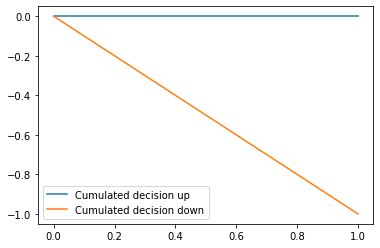

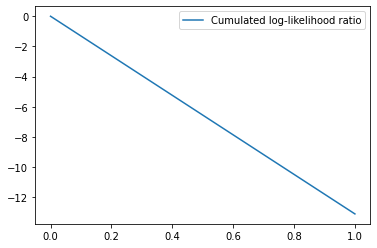

In [ ]:
# Function to generate the sensor inputs
# Parameter: strd_up - float - standard deviation of the up distribution
#            strd_down - float - the standard deviation of the down distribution
#            real_direction - boolean - real direction is up(1) or down(0)
#            nbr_trials - interger - number times the experience is repeated
# Return: sensory inputs - numpy array
def sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials):
  mean_up = 0.75
  mean_down = 0.25
  # np.random.seed(100)
  rv_up = truncnorm((0-mean_up)/strd_up, (1-mean_up)/strd_up, loc=mean_up,scale=strd_up)
  rv_down = truncnorm((0-mean_down)/strd_down, (1-mean_down)/strd_down, loc=mean_down,scale=strd_down)
  if real_direction == 1:
    sensor_inputs = rv_up.rvs(size=nbr_trials)
  else:
    sensor_inputs = rv_down.rvs(size=nbr_trials)
  # np.set_printoptions(precision=3)
  # print(sensor_inputs)
  # x = np.linspace(-0,1,100)
  # plt.plot(x, rv_down.pdf(x)/np.sum(rv_down.pdf(x)))
  # # plt.plot(x, truncnorm.pdf(x,0,1)/np.sum(truncnorm.pdf(x,0,1)))
  # plt.show()
  return sensor_inputs

# Function to performs the probability ratio test
# Inputs : strd_up is the standard deviation of the up distribution
#          strd_down is the standard deviation of the down distribution
#          real_direction is a binary variable telling us if the real direction is up(1) or down(0)
#          likelihood [0, 1] = [normal, sigmoid]
# Output : ll_ratio
#          decision 0(down) or 1(up)
def decision_making(strd_down, strd_up, real_direction, nbr_trials, likelihood, param):
  mean_up = 0.75
  mean_down = 0.25
  x = np.linspace(0,1,100)

  sensor_inputs = sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials)
  if likelihood == 0:
    ll_ratio = normal_ll_ratio(sensor_inputs, mean_down, mean_up, param[0], param[1])
  elif likelihood == 1:
    ll_ratio = sigmoid_ll_ratio(sensor_inputs, 0.25, 0.75, param[1])
  elif likelihood == 2:
    ll_ratio = linear_ll_ratio(sensor_inputs, m, p)

  decision_up = [0]
  decision_down = [0]
  decision = [0]
  for i in ll_ratio:
    decision.append(decision[-1] + i)
    if i > 0:
      decision_up.append(decision_up[-1]+1)
      decision_down.append(decision_down[-1])
    elif i < 0:
      decision_up.append(decision_up[-1])
      decision_down.append(decision_down[-1]+1)
    # else:  Pas sûr qu'il aie besoin de le mettre
    # decision = np.random.randint(2)

  return np.array(decision_up), np.array(decision_down), np.array(decision)

strd_down = 0.2
strd_up = 0.2
nbr_trials =1
param = [0.2, 0.1] # param of sigmoid or variance of likelihood
decision_up, decision_down, decision = decision_making(strd_down, strd_up, 1, nbr_trials, 0, param)

plt.plot(range(len(decision_up)), decision_up, color="C0", label='Cumulated decision up')
print("Percentage of succes: ", 100*decision_up[-1]/nbr_trials,"%")
plt.plot(range(len(decision_up)), -1*decision_down, color="C1", label='Cumulated decision down')
plt.legend()
plt.show()

plt.plot(range(len(decision)), decision, color="C0", label='Cumulated log-likelihood ratio')
plt.legend()
plt.show()

**To do**
*   **Problem with the normalization of the distribution (surtout sigmoid, il faut renormalizer sur l'interval [0, 1]: bricolage)**
*   **Why is it important to normalize?**
*   likelihood: polynome, gamma?
*   discrétisation "forcée" f des distributions <-> variance dépend de n ?
*   Faire des expériences
*   creation prior
*   Multivariate gaussian (distance entre les flèches)




-Reste encore à trouver une dépendance de strd avec le nombre de flèches montrée

Je pense que c'est représentatif là et interpretable. Si on augmente les strd, je prend comme exemple strd_up=strd_down=0.5 et je fais 50 trials tout en disant que la réponse est 0(down). On peut voir certaines fois qu'après genre 10 trials la décision n'est pas encore claire, la ligne bleu passe un petit coup au dessus de la orange, ce qui pour moi signifie qu'il est plus chaud de choisir le bleu que le orange si on s'arrete là. Evidemment puisqu'on prend des valeurs random, parfois la décision est directement très bien prise et reste la bonne tout le temps mais parfois on pourrait dire que le singe est susceptible de se tromper.

**Decision making based on prior knowledge**

Du coup faut encore prendre en compte :

    1. que la réussite devrait augmenter si le nbr de trial est élevé 
    2. que la réussite devrait diminuer si le nombre de flèche n augmente

Pour le point 1 du coup on va faire en sorte de biaiser une des normale en fonction du nbr_trials. 


Pour le point 2 je pense que c'est plus facile de faire augmenter la strd en fonction de n de façon a retrouver la même courbe de pourcentage de réussite exponentielle


Percentage of succes:  77.6 %


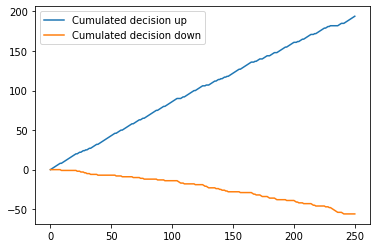

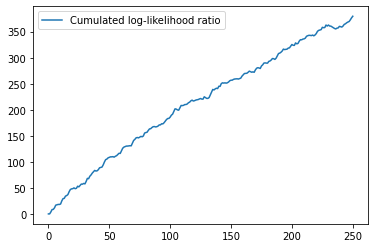

In [ ]:
# Function to performs the probability ratio test
# Inputs : strd_up is the standard deviation of the up distribution
#          strd_down is the standard deviation of the down distribution
#          real_direction is a binary variable telling us if the real direction is up(1) or down(0)
#          likelihood [0, 1] = [normal, sigmoid]
# Output : ll_ratio
#          decision 0(down) or 1(up)
def decision_making_prior(strd_down, strd_up, real_direction, nbr_trials, likelihood, param):
  mean_up = 0.75
  mean_down = 0.25

  sensor_inputs = sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials)
  if likelihood == 0:
    ll_ratio = normal_ll_ratio(sensor_inputs, mean_down, mean_up, param[0], param[1])
  elif likelihood == 1:
    ll_ratio = sigmoid_ll_ratio(sensor_inputs, 0.25, 0.75, param[1])
    
  return ll_ratio[0]

def decision_making_posterior(strd_down, strd_up, real_direction, nbr_trials, likelihood, param_ref): 
  param = param_ref.copy()
  decision_up = [0]
  decision_down = [0]
  decision = [0]
  for i in range(nbr_trials):   
    i = decision_making_prior(strd_down, strd_up, real_direction, 1, likelihood, param)
    decision.append(decision[-1] + i)
    if i>0:
      decision_up.append(decision_up[-1]+1)
      decision_down.append(decision_down[-1])
      if param[0] != param_ref[0]:
        param[0] -= 0.01
      else:
        param[1] += 0.01
    elif i < 0: 
      decision_up.append(decision_up[-1])
      decision_down.append(decision_down[-1]+1)
      if param[1] != param_ref[1]:
        param[1] -= 0.01
      else:
        param[0] += 0.01
  return decision_up, decision_down, decision


param_ref = [0.2, 0.2]
strd_down = 0.2
strd_up = 0.2
nbr_trials =250

decision_up1, decision_down1, decision1 = decision_making_posterior(strd_down, strd_up, 1, nbr_trials, 0, param_ref)

plt.plot(range(len(decision_up1)), decision_up1, color="C0", label='Cumulated decision up')
print("Percentage of succes: ", 100*decision_up1[-1]/nbr_trials,"%")
plt.plot(range(len(decision_up1)), -1*np.array(decision_down1), color="C1", label='Cumulated decision down')
plt.legend()
plt.show()

plt.plot(range(len(decision1)), decision1, color="C0", label='Cumulated log-likelihood ratio')
plt.legend()
plt.show()

**Distribution of the posterior**
---------------

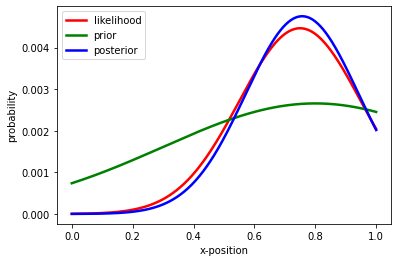

In [ ]:
def compute_posterior_pointwise(prior, likelihood):
    ''' 
    Returns the normalized posterior probability based on the prior and the likelihood
    Prior: The prior probabilities
    Likelihood: The likelihood probabilities
    '''
    posterior = prior * likelihood
    posterior /= posterior.sum()
    return posterior


x = np.linspace(0, 1, 500)

likelihood = normal_distribution(x,0.75,0.2)
prior = normal_distribution(x,0.8,0.5)
posterior = compute_posterior_pointwise(prior,likelihood)


fig, ax = plt.subplots()
ax.plot(x,likelihood,'r',Linewidth=2.5,label='likelihood')
ax.plot(x,prior,'g',Linewidth=2.5,label='prior')
ax.plot(x,posterior,'b',Linewidth=2.5,label='posterior')
ax.set_xlabel('x-position')
ax.set_ylabel('probability')
ax.legend()


---------------
# **Analysis of the model**
---------------

*   Fit les données de succes - fonction dépendant de n
*   Plot % de réussite en fonction de la variance. Regarder avec mean données
*   Trouver façon d'analyser/interpréter les données
*   **Trouver une façon de comparer (l'impact) les différents likelihood !!!**

**Analysis of Gaussian likelihood**
-------------------

In [ ]:
def exponential_fitting(data):
  x = np.linspace(0, 2.2, 501)[1:-1]
  t = np.linspace(0, 2.2, 501)[1:-1]
  def residual(p, x, data):
      return data - p[0]*np.exp(x/p[1]) - p[2]
  param, pcov = leastsq(residual, [0, -1, 0], args=(x, data))
  y = param[2] + param[0]*np.exp(t/param[1])
  print("Paramètres :", param)
  return t, y

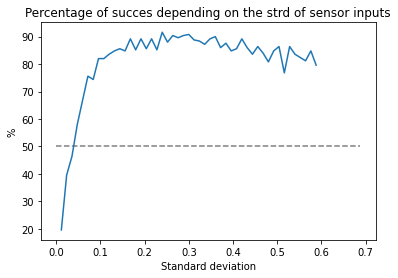

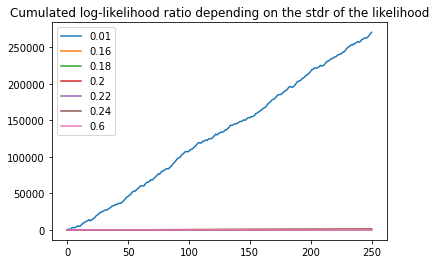

In [ ]:
#Plot percentage of succes (1) depending on the variance of the likelihood (normal)
succes = []
param = [0.02, 0.02]
# param = [2, 2]
nbr_trials = 250
# interv = range(10)
interv = np.linspace(0, 0.6, 51)[1:-1]
# interv = np.linspace(0, 2.2, 501)[1:-1]

for i in interv:
  # i += 0.01
  # decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 0, param)
  decision_up, decision_down, decision = decision_making(0.2, 0.2, 1, nbr_trials, 0, [0.2, i])
  percentage_of_succes = 100*decision_up[-1]/nbr_trials
  succes.append(percentage_of_succes)

plt.plot(interv, np.array(succes), '-', label="Percentage of succes")
plt.hlines(50, 0, np.max(interv+0.1), colors='C7', linestyles='dashed', linewidth=1.5)
# t, y = exponential_fitting(succes)
# plt.plot(t, y, linewidth=2)
plt.xlabel("Standard deviation")
plt.ylabel("%")
plt.title("Percentage of succes depending on the strd of sensor inputs")
plt.show()

for i in [0.01,0.16, 0.18, 0.2, 0.22, 0.24, 0.6]:
# for i in [0.04, 0.06, 0.08, 0.1, 0.15, 0.2]:
# for i in [0.8, 1, 1.2, 1.5, 1.8, 2]:
  # i += 0.01
  # decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 0, param)
  decision_up, decision_down, decision = decision_making(0.2, 0.2, 1, nbr_trials, 0, [i, i])
  plt.plot(range(len(decision)), decision, label=str(i)) 

plt.legend()
plt.title('Cumulated log-likelihood ratio depending on the stdr of the likelihood')
plt.show()

**Analyse:**
* we can remark that the variance of the likelihood has no impact on the precentage of right decision because that doesn't take into account the force with which it was made. The second graph of cumulated log-likelihood shows, the log ratio decreases when the variance increase* (rapidly for small value). The patient takes the good decision but with less and less certainties.
* The variance used on the generation of the sensor inputs has an "huge" inpact on the percentage of success. That converges rapidly to 50% which amounts to choosing at random. Then you have 50% of chance to get the right answer.

* j'ai changé decrease par increase ça me paraissait plus logique au vu du graphe

**Analysis of sigmoid likelihood**
----------------------

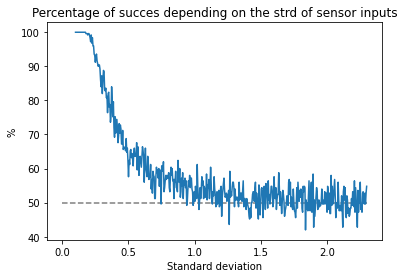

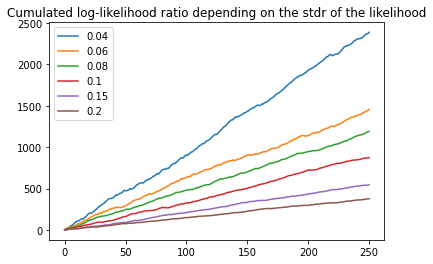

In [ ]:
#Plot percentage of succes (1) depending on the variance of the likelihood (sigmoid)
succes = []
param = [0, 0.01]
nbr_trials = 250
# interv = np.linspace(0, 5,51)
interv = np.linspace(0, 2.2,501)

for i in interv:
  i += 0.01
  decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 1, param)
  percentage_of_succes = 100*decision_up[-1]/nbr_trials
  succes.append(percentage_of_succes)

plt.plot((interv+0.1), np.array(succes), '-', label="Percentage of succes")
plt.hlines(50, 0, np.max(interv+0.1), colors='C7', linestyles='dashed', linewidth=1.5)
plt.xlabel("Standard deviation")
plt.ylabel("%")
plt.title("Percentage of succes depending on the strd of sensor inputs")
plt.show()

param = [None, 0.01]
# for i in np.linspace(0, 2, 11)[1:-1]:
for i in [0.04, 0.06, 0.08, 0.1, 0.15, 0.2]:
# for i in [0.8, 1, 1.2, 1.5, 1.8, 2]:
  # i += 0.01
  # decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 1, param)
  decision_up, decision_down, decision = decision_making(0.2, 0.2, 1, nbr_trials, 1, [None, i])
  plt.plot(range(len(decision)), decision, label=str(i)) 
plt.legend()
plt.title('Cumulated log-likelihood ratio depending on the stdr of the likelihood')
plt.show()

**Analysis of linear likelihood**
-----------------

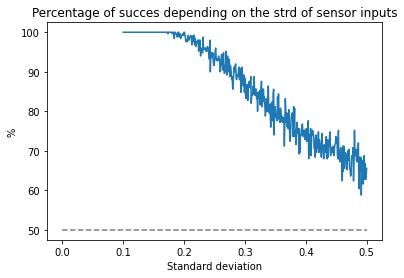

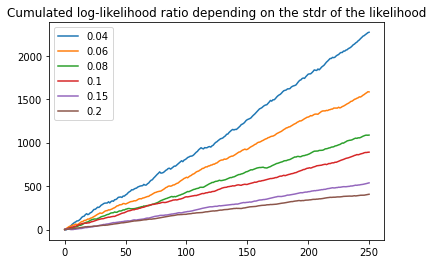

In [ ]:
#Plot percentage of succes (1) depending on the variance of the likelihood (sigmoid)
succes = []
param = [0, 1] # param[1] = m
nbr_trials = 250
interv = np.linspace(0, 0.4,501)
# interv = np.linspace(0, 2.2,501)

for i in interv:
  i += 0.01
  decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 1, param)
  percentage_of_succes = 100*decision_up[-1]/nbr_trials
  succes.append(percentage_of_succes)

plt.plot((interv+0.1), np.array(succes), '-', label="Percentage of succes")
plt.hlines(50, 0, np.max(interv+0.1), colors='C7', linestyles='dashed', linewidth=1.5)
plt.xlabel("Standard deviation")
plt.ylabel("%")
plt.title("Percentage of succes depending on the strd of sensor inputs")
plt.show()

param = [None, 0.01]
# for i in np.linspace(0, 2, 11)[1:-1]:
for i in [0.04, 0.06, 0.08, 0.1, 0.15, 0.2]:
# for i in [0.8, 1, 1.2, 1.5, 1.8, 2]:
  # i += 0.01
  # decision_up, decision_down, decision = decision_making(i, i, 1, nbr_trials, 1, param)
  decision_up, decision_down, decision = decision_making(0.2, 0.2, 1, nbr_trials, 1, [None, i])
  plt.plot(range(len(decision)), decision, label=str(i)) 
plt.legend()
plt.title('Cumulated log-likelihood ratio depending on the stdr of the likelihood')
plt.show()

-----------------
# **Multivariate Gaussian**
------------------

In [ ]:
# Function to generate a multivariare gaussian function of a vector x and a vector y
# Return: the probabilities at x,y
def multivariate_gaussian(meanx, meany, strdx, strdy):

  prob = multivariate_normal([meanx, meany], [[strdx, 0], [0, strdy]])
  return prob


#Parameters mean and stdr in X and Y

meanup_x= 0.75
strdup_x= 0.5
meanup_y= 0.25
strdup_y= 0.5

meandown_x= 0.25
strddown_x= 0.5
meandown_y= 0.75
strddown_y= 0.5

#Create grid and multivariate normal
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
Z = np.empty(X.shape + (2,))
Z[:, :, 0] = X; Z[:, :, 1] = Y

# True and estmated state of the arrow up
p_up = multivariate_gaussian(meanup_x, meanup_y, strdup_x, strdup_y)
# True and estmated state of the arrow down
p_down = multivariate_gaussian(meandown_x, meandown_y, strddown_x, strddown_y)

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, p_up.pdf(Z),cmap='viridis',linewidth=0)
ax.plot_surface(X, Y, p_down.pdf(Z),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
'''
# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.pause(.001)
'''
plt.show()

In [ ]:
# Function to generate the sensor inputs
# Parameter: strd_up - float - standard deviation of the up distribution
#            strd_down - float - the standard deviation of the down distribution
#            real_direction - boolean - real direction is up(1) or down(0)
#            nbr_trials - interger - number times the experience is repeated
# Return: sensory inputs - numpy array
def sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials):
  mean_up = 0.75
  mean_down = 0.25
  # np.random.seed(100)
  rv_up = truncnorm((0-mean_up)/strd_up, (1-mean_up)/strd_up, loc=mean_up,scale=strd_up)
  rv_down = truncnorm((0-mean_down)/strd_down, (1-mean_down)/strd_down, loc=mean_down,scale=strd_down)
  if real_direction == 1:
    sensor_inputs = rv_up.rvs(size=nbr_trials)
  else:
    sensor_inputs = rv_down.rvs(size=nbr_trials)
  # np.set_printoptions(precision=3)
  # print(sensor_inputs)
  # x = np.linspace(-0,1,100)
  # plt.plot(x, rv_down.pdf(x)/np.sum(rv_down.pdf(x)))
  # # plt.plot(x, truncnorm.pdf(x,0,1)/np.sum(truncnorm.pdf(x,0,1)))
  # plt.show()
  return sensor_inputs

# Function to performs the probability ratio test
# Inputs : strd_up is the standard deviation of the up distribution
#          strd_down is the standard deviation of the down distribution
#          real_direction is a binary variable telling us if the real direction is up(1) or down(0)
#          likelihood [0, 1] = [normal, sigmoid]
# Output : ll_ratio
#          decision 0(down) or 1(up)
def decision_making(strd_down, strd_up, real_direction, nbr_trials, likelihood, param):
  mean_up = 0.75
  mean_down = 0.25
  x = np.linspace(0,1,100)

  sensor_inputs = sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials)
  if likelihood == 0:
    ll_ratio = normal_ll_ratio(sensor_inputs, mean_down, mean_up, param[0], param[1])
  elif likelihood == 1:
    ll_ratio = sigmoid_ll_ratio(sensor_inputs, 0.25, 0.75, param[1])
  elif likelihood == 2:
    ll_ratio = linear_ll_ratio(sensor_inputs, m, p)

  decision_up = [0]
  decision_down = [0]
  decision = [0]
  for i in ll_ratio:
    decision.append(decision[-1] + i)
    if i > 0:
      decision_up.append(decision_up[-1]+1)
      decision_down.append(decision_down[-1])
    elif i < 0:
      decision_up.append(decision_up[-1])
      decision_down.append(decision_down[-1]+1)
    # else:  Pas sûr qu'il aie besoin de le mettre
    # decision = np.random.randint(2)

  return np.array(decision_up), np.array(decision_down), np.array(decision)

strd_down = 0.2
strd_up = 0.2
nbr_trials =1
param = [0.2, 0.1] # param of sigmoid or variance of likelihood
decision_up, decision_down, decision = decision_making(strd_down, strd_up, 1, nbr_trials, 0, param)

plt.plot(range(len(decision_up)), decision_up, color="C0", label='Cumulated decision up')
print("Percentage of succes: ", 100*decision_up[-1]/nbr_trials,"%")
plt.plot(range(len(decision_up)), -1*decision_down, color="C1", label='Cumulated decision down')
plt.legend()
plt.show()

plt.plot(range(len(decision)), decision, color="C0", label='Cumulated log-likelihood ratio')
plt.legend()
plt.show()